### For updated features based on the ppp_transformed_updated.csv

Transformations include:
- Converting Term from numeric/ordinal to categorical (less than 24, 24, between 24 and 60, 60, more than 60)
    - Justification: most concentrated around 24 and 60. the standard for ppp is 24 months, but can be extended to 60 months
    - Could also see it as whether a loan extension was applied
- Log transformation on large numeric variables
    - Normalises the data before standardising
    - MinMax shrinks the range but preserves the skew
    - shrinking 0-1B to 0-1 results in long decimals (eg. 0.988887622845627891), which usually gets binned together
    - new columns will be standardised as well
- Including dummy variables 
- Splitting dataset based on original (non-categorical), encoded, scaled_standardised, log_standardised, dummy

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("ppp_transformed_updated.csv")
df_original = df.copy()
df.columns

Index(['Unnamed: 0', 'LoanNumber', 'DateApproved', 'SBAOfficeCode',
       'ProcessingMethod', 'BorrowerName', 'BorrowerCity', 'BorrowerState',
       'BorrowerZip', 'LoanStatus', 'Term', 'InitialApprovalAmount',
       'CurrentApprovalAmount', 'FranchiseName', 'ServicingLenderName',
       'ServicingLenderZip', 'RuralUrbanIndicator', 'HubzoneIndicator',
       'LMIIndicator', 'BusinessAgeDescription', 'ProjectCity', 'JobsReported',
       'NAICSCode', 'Race', 'Ethnicity', 'BusinessType', 'Gender', 'Veteran',
       'TOTAL_PROCEED', 'PROCEED_Diff', 'UTILITIES_PROCEED_pct',
       'PAYROLL_PROCEED_pct', 'MORTGAGE_INTEREST_PROCEED_pct',
       'RENT_PROCEED_pct', 'REFINANCE_EIDL_PROCEED_pct',
       'HEALTH_CARE_PROCEED_pct', 'DEBT_INTEREST_PROCEED_pct',
       'PROCEED_Per_Job', 'isAfterBiden', 'isDiffBorrowerAndProjectCity',
       'Industry', 'Subsector', 'ProcessingMethod_encoded',
       'LoanStatus_encoded', 'RuralUrbanIndicator_encoded',
       'HubzoneIndicator_encoded', 'LMIIndi

#### Converting 'Term' to categorical

In [3]:
def term_transform(row):
    """
    Transforms 'Term' column into a new column with categorical (string) values
    > 60  : more than 60
    == 60 : 60
    > 24  : between 24 and 60
    == 24 : 24
    < 24  : less than 24 
    """
    if row > 60:
        label = 'more_than_60'
    elif row == 60:
        label = 'is_60'
    elif row > 24:
        label = 'between_24_60'
    elif row == 24:
        label = 'is_24'
    else:
        label = 'less_than_24'
    return label

In [4]:
# transform Term column into categorical
df['Term_cat'] = df['Term'].apply(term_transform)
df[['Term', 'Term_cat']].head(5)

,Term,Term_cat
0,24,is_24
1,24,is_24
2,24,is_24
3,24,is_24
4,24,is_24


### Log-transform 'InitialApprovalAmount','CurrentApprovalAmount','TOTAL_PROCEED','PROCEED_Per_Job','JobsReported'
'PROCEED_Diff' not log-transformed due to log(0) resulting in -inf, please use the original scaled_standard

In [5]:
# following variables are significantly large in scale
big = ['InitialApprovalAmount','CurrentApprovalAmount','TOTAL_PROCEED','PROCEED_Per_Job','JobsReported']

for var in big:
    #df[f'log_{var}'] = np.log(df[var]) 
    df[f'log_{var}'] = [np.log(x) if x > 0 else 0 for x in df[var]]

Comparing columns before and after transformation, we expect the x-axis to be more manageable.

In [6]:
# fig, axes = plt.subplots(1,2, figsize = (16,4))

# sns.histplot(df[['InitialApprovalAmount']], kde = True, ax = axes[0])
# sns.histplot(df[['log_InitialApprovalAmount']], kde = True, ax = axes[1])
# plt.tight_layout()
# plt.show()

In [7]:
# fig, axes = plt.subplots(1,2, figsize = (16,4))

# sns.histplot(df[['CurrentApprovalAmount']], kde = True, ax = axes[0])
# sns.histplot(df[['log_CurrentApprovalAmount']], kde = True, ax = axes[1])
# plt.tight_layout()
# plt.show()

In [8]:
# fig, axes = plt.subplots(1,2, figsize = (16,4))

# sns.histplot(df[['TOTAL_PROCEED']], kde = True, ax = axes[0])
# sns.histplot(df[['log_TOTAL_PROCEED']], kde = True, ax = axes[1])
# plt.tight_layout()
# plt.show()

In [9]:
# fig, axes = plt.subplots(1,2, figsize = (16,4))

# sns.histplot(df[['PROCEED_Per_Job']], kde = True, ax = axes[0])
# sns.histplot(df[['log_PROCEED_Per_Job']], kde = True, ax = axes[1])
# plt.tight_layout()
# plt.show()

In [10]:
# fig, axes = plt.subplots(1,2, figsize = (16,4))

# sns.histplot(df[['JobsReported']], kde = True, ax = axes[0])
# sns.histplot(df[['log_JobsReported']], kde = True, ax = axes[1])
# plt.tight_layout()
# plt.show()

### Standardising log-transformed variables

In [11]:
log_to_standardise = ['log_InitialApprovalAmount','log_CurrentApprovalAmount', 'log_TOTAL_PROCEED','log_PROCEED_Per_Job','log_JobsReported']

scaler = StandardScaler()

for field in log_to_standardise:
    df[f'{field}_standardised'] = scaler.fit_transform(df[[field]])

### Percentages variables transformation

Since all _pct variables are summed to 1 for each row, and noticing that most rows have 1 to PAYROLL_PROCEED_pct (indicating 100% allocation to payroll), we will take a ratio of proceeds that went to payroll versus proceeds that went to all other aspects. 

The formula: ln((1+payroll_proceed_pct)/(1+sum(all other pct)))

1 is added to numerator and denominator to aid in calculation

In [12]:
payroll_scaler = StandardScaler()

df['payroll_over_other'] = np.log((1+df['PAYROLL_PROCEED_pct'])/(1+df[['UTILITIES_PROCEED_pct','MORTGAGE_INTEREST_PROCEED_pct','RENT_PROCEED_pct',
                                                                       'REFINANCE_EIDL_PROCEED_pct','HEALTH_CARE_PROCEED_pct','DEBT_INTEREST_PROCEED_pct'
                                                                       ]].sum(axis=1)))

df['payroll_over_other'] = payroll_scaler.fit_transform(df['payroll_over_other'].values.reshape((-1, 1)))

Just for clarity, the dataframes will be split into 

1. Original dataset as loaded (df_original)
2. Dataset as transformed up to now (df_new)

Lists of various variables are provided, please feel free to drop accordingly.

If your model requires dummy variables, please use the next section.

In [13]:
# list of encoded variables
encoded = ['ProcessingMethod_encoded','LoanStatus_encoded','RuralUrbanIndicator_encoded','HubzoneIndicator_encoded','LMIIndicator_encoded',
           'BusinessAgeDescription_encoded','Race_encoded','Ethnicity_encoded','BusinessType_encoded','Gender_encoded','Veteran_encoded','Industry_encoded']

# list of existing standardised variables
standardised = ['Term_standardised','JobsReported_standardised','PROCEED_Diff_standardised','UTILITIES_PROCEED_pct_standardised','PAYROLL_PROCEED_pct_standardised',
                'MORTGAGE_INTEREST_PROCEED_pct_standardised','RENT_PROCEED_pct_standardised','REFINANCE_EIDL_PROCEED_pct_standardised','HEALTH_CARE_PROCEED_pct_standardised',
                'DEBT_INTEREST_PROCEED_pct_standardised','InitialApprovalAmount_scaled_standardised','CurrentApprovalAmount_scaled_standardised','TOTAL_PROCEED_scaled_standardised',
                'PROCEED_Per_Job_scaled_standardised']

# list of log_transformed variables
logged = ['log_InitialApprovalAmount','log_CurrentApprovalAmount','log_TOTAL_PROCEED','log_PROCEED_Per_Job','log_JobsReported']

# list of log_transformed_standardised variables
log_standardise = ['log_InitialApprovalAmount_standardised','log_CurrentApprovalAmount_standardised','log_TOTAL_PROCEED_standardised',
                   'log_PROCEED_Per_Job_standardised','log_JobsReported_standardised']

# list of pct variables
pct = ['PAYROLL_PROCEED_pct','UTILITIES_PROCEED_pct','MORTGAGE_INTEREST_PROCEED_pct','RENT_PROCEED_pct','REFINANCE_EIDL_PROCEED_pct','HEALTH_CARE_PROCEED_pct','DEBT_INTEREST_PROCEED_pct']

# list of commonly dropped varibles (please feel free to use your own)
# drop = ['Unnamed: 0', 'LoanNumber','DateApproved','SBAOfficeCode','BorrowerName','BorrowerCity','BorrowerZip','Term','InitialApprovalAmount','CurrentApprovalAmount',
#         'FranchiseName','ServicingLenderName','ServicingLenderZip','BusinessAgeDescription', 'ProjectCity','NAICSCode','TOTAL_PROCEED','PROCEED_Diff']
drop = ['Unnamed: 0', 'LoanNumber','DateApproved','SBAOfficeCode','BorrowerName','BorrowerCity','BorrowerZip','Term','InitialApprovalAmount','CurrentApprovalAmount',
        'FranchiseName','ServicingLenderName','ServicingLenderZip', 'ProjectCity','NAICSCode','TOTAL_PROCEED','PROCEED_Diff', 'Subsector', 'BusinessType']
# original dataframe from ppp_transformed_updated.csv
# df_original

# original dataframe with Term transformation, log transformation, log standardised and dummies -> new dataframe transformed up to now
df_new = df.copy()

In [14]:
# drop columns that are not required in your model
df_new = df_new.drop(columns=drop+encoded+standardised+pct, axis=1)

### Creating dummy variables

In [15]:
df_model = df_new # please add the dataframe you are using

# dummies = ['BorrowerState', 'Term_cat','ProcessingMethod','LoanStatus','RuralUrbanIndicator','HubzoneIndicator',
#            'LMIIndicator','BusinessAgeDescription','Race','Ethnicity','BusinessType','Gender',
#            'Veteran','Industry']

dummies = ['BorrowerState', 'Term_cat','ProcessingMethod','LoanStatus','RuralUrbanIndicator','HubzoneIndicator',
           'LMIIndicator','BusinessAgeDescription','Race','Ethnicity','Gender',
           'Veteran', 'Industry']

df_with_dummies = df_model.copy()
df_with_dummies = pd.get_dummies(df_with_dummies, columns = dummies, drop_first=False)

df_with_dummies.columns

Index(['JobsReported', 'PROCEED_Per_Job', 'isAfterBiden',
       'isDiffBorrowerAndProjectCity', 'isFraud', 'log_InitialApprovalAmount',
       'log_CurrentApprovalAmount', 'log_TOTAL_PROCEED', 'log_PROCEED_Per_Job',
       'log_JobsReported',
       ...
       'Industry_Mining, quarrying, and oil and gas extraction',
       'Industry_Nonclassifiable establishment',
       'Industry_Other services (except public administration) ',
       'Industry_Professional, scientific, and technical services',
       'Industry_Public service ',
       'Industry_Real estate and rental and leasing', 'Industry_Retail trade',
       'Industry_Transportation and warehousing', 'Industry_Utilities',
       'Industry_Wholesale trade'],
      dtype='object', length=133)

# Supervised Modeling

In [16]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, RandomOverSampler, SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, recall_score, RocCurveDisplay, roc_curve

from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import itertools

import shap
shap.initjs()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [17]:
X = df_with_dummies.drop(columns=['isFraud'])
y = df_with_dummies['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test)

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

In [18]:
df_new[dummies] = df_new[dummies].astype('category')
X_smnc, y_smnc = df_new.drop(columns=['isFraud']), df_new['isFraud']

X_train_smnc, X_test_smnc, y_train_smnc, y_test_smnc = train_test_split(X_smnc, y_smnc, test_size=0.2, stratify=y_smnc)


smnc = SMOTENC(random_state=42,categorical_features=dummies)
X_train_smnc, y_train_smnc = smnc.fit_resample(X_train_smnc, y_train_smnc)

In [19]:
# Functions

def get_report(y_test, y_pred):
    print('classification_report\n------------------------------------')
    print(classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud']))
    print('\nrecall_score\n------------------------------------')
    print(recall_score(y_test, y_pred))
    print('\nroc_auc_score\n------------------------------------')
    print(roc_auc_score(y_test, y_pred, ))
    print('\nconfusion_matrix\n------------------------------------')
    conf_matrix = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(conf_matrix, classes=['Normal', 'Fraud'])
    sm_val_correct = conf_matrix[0][0] + conf_matrix[1][1]
    print('> Correct Predictions:', sm_val_correct)
    sm_val_wrong = conf_matrix[1][0] + conf_matrix[0][1]
    print('> Wrong Predictions:', sm_val_wrong)
    sm_val_fpr, sm_val_tpr, _ = roc_curve(y_test, y_pred)
    sm_display = RocCurveDisplay(fpr=sm_val_fpr, tpr=sm_val_tpr)
    sm_display.plot()


def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    labels = ['Normal','Fraud']

## XGB random forest

------------------------------------
Base Model Stats
classification_report
------------------------------------
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    192274
       Fraud       0.59      0.64      0.61       105

    accuracy                           1.00    192379
   macro avg       0.80      0.82      0.81    192379
weighted avg       1.00      1.00      1.00    192379


recall_score
------------------------------------
0.638095238095238

roc_auc_score
------------------------------------
0.8189279980900273

confusion_matrix
------------------------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Confusion matrix, without normalization
[[192228     46]
 [    38     67]]
> Correct Predictions: 192295
> Wrong Predictions: 84


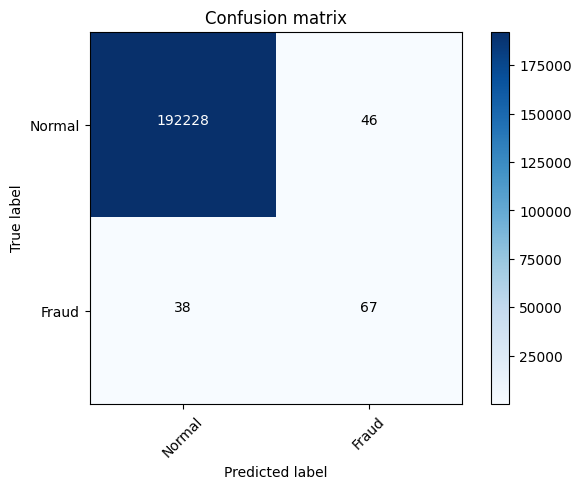

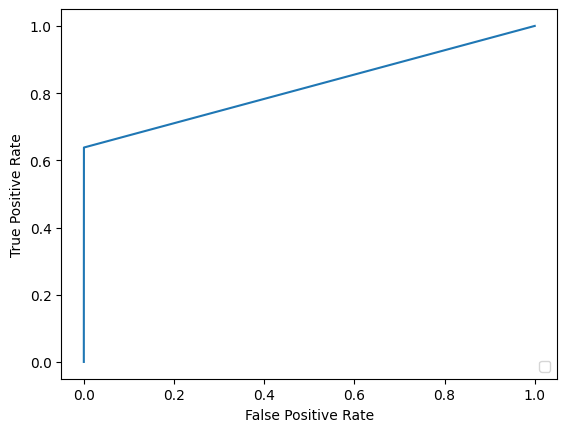

In [20]:
xgb_model = xgb.XGBRFClassifier(n_estimators = 1500, n_jobs = -1, random_state = 42, tree_method = 'gpu_hist', gpu_id=0)
xgb_model.fit(X_train, y_train)
xgb_y_pred = xgb_model.predict(X_test)

print('------------------------------------\nBase Model Stats')
get_report(y_test, xgb_y_pred)

------------------------------------
Base Model + SMOTE Stats
classification_report
------------------------------------
              precision    recall  f1-score   support

   Not Fraud       1.00      0.99      1.00    192274
       Fraud       0.07      0.84      0.14       105

    accuracy                           0.99    192379
   macro avg       0.54      0.92      0.57    192379
weighted avg       1.00      0.99      1.00    192379


recall_score
------------------------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.8380952380952381

roc_auc_score
------------------------------------
0.9161637137874175

confusion_matrix
------------------------------------
Confusion matrix, without normalization
[[191165   1109]
 [    17     88]]
> Correct Predictions: 191253
> Wrong Predictions: 1126


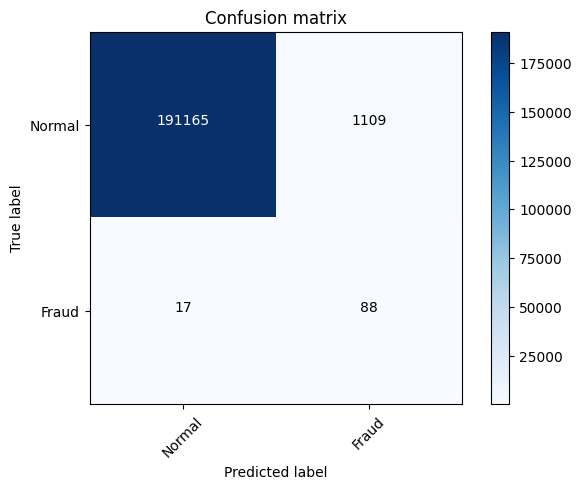

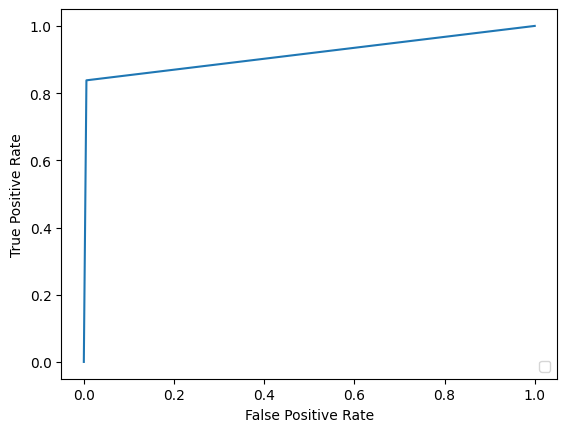

In [21]:
xgb_model_sm = xgb.XGBRFClassifier(n_estimators = 1500, n_jobs = -1, random_state = 42, tree_method = 'gpu_hist', gpu_id=0)
xgb_model_sm.fit(X_train_sm, y_train_sm)
xgb_y_pred_sm = xgb_model_sm.predict(X_test)

print('------------------------------------\nBase Model + SMOTE Stats')
get_report(y_test, xgb_y_pred_sm)

------------------------------------
Base Model + Random Under Sampling Stats
classification_report
------------------------------------
              precision    recall  f1-score   support

   Not Fraud       1.00      0.96      0.98    192274
       Fraud       0.01      0.93      0.03       105

    accuracy                           0.96    192379
   macro avg       0.51      0.95      0.50    192379
weighted avg       1.00      0.96      0.98    192379


recall_score
------------------------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.9333333333333333

roc_auc_score
------------------------------------
0.9481046145951437

confusion_matrix
------------------------------------
Confusion matrix, without normalization
[[185136   7138]
 [     7     98]]
> Correct Predictions: 185234
> Wrong Predictions: 7145


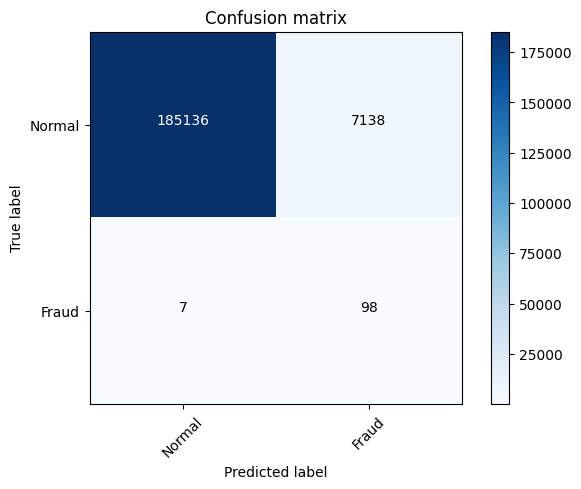

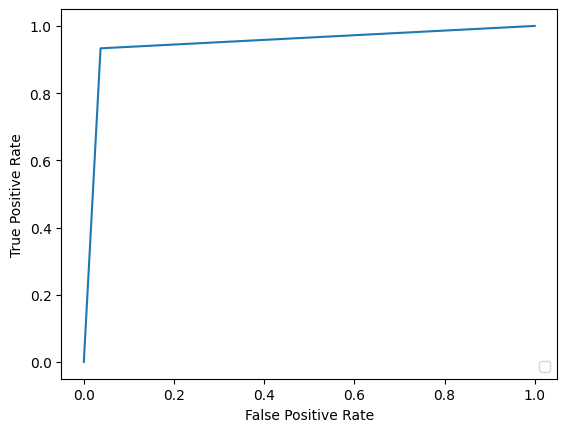

In [22]:
xgb_model_rus = xgb.XGBRFClassifier(n_estimators = 1500, n_jobs = -1, random_state = 42, tree_method = 'gpu_hist', gpu_id=0)
# X_train_xgb = np.array(X_train)
xgb_model_rus.fit(X_train_rus, y_train_rus)
xgb_y_pred_rus = xgb_model_rus.predict(X_test)

print('------------------------------------\nBase Model + Random Under Sampling Stats')
get_report(y_test, xgb_y_pred_rus)

------------------------------------
Base Model + Random Under Sampling Stats
classification_report
------------------------------------
              precision    recall  f1-score   support

   Not Fraud       1.00      0.98      0.99    192274
       Fraud       0.02      0.91      0.04       105

    accuracy                           0.98    192379
   macro avg       0.51      0.94      0.51    192379
weighted avg       1.00      0.98      0.99    192379


recall_score
------------------------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.9142857142857143

roc_auc_score
------------------------------------
0.9448270994221044

confusion_matrix
------------------------------------
Confusion matrix, without normalization
[[187538   4736]
 [     9     96]]
> Correct Predictions: 187634
> Wrong Predictions: 4745


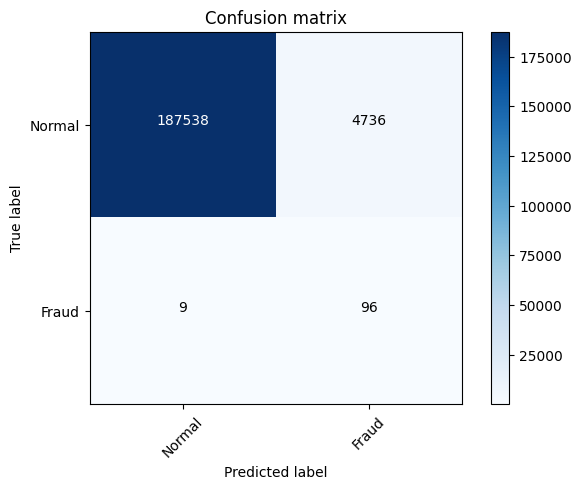

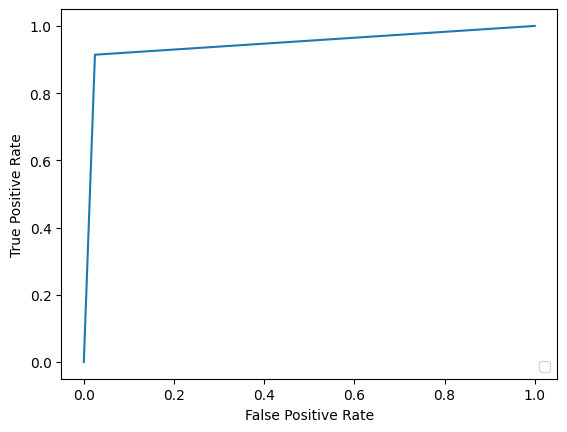

In [23]:
xgb_model_ros = xgb.XGBRFClassifier(n_estimators = 1500, n_jobs = -1, random_state = 42, tree_method = 'gpu_hist', gpu_id=0)
# X_train_xgb = np.array(X_train)
xgb_model_ros.fit(X_train_ros, y_train_ros)
xgb_y_pred_ros = xgb_model_ros.predict(X_test)

print('------------------------------------\nBase Model + Random Under Sampling Stats')
get_report(y_test, xgb_y_pred_ros)

------------------------------------
Base Model + SMOTENC Stats
classification_report
------------------------------------
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    192274
       Fraud       0.15      0.77      0.24       105

    accuracy                           1.00    192379
   macro avg       0.57      0.88      0.62    192379
weighted avg       1.00      1.00      1.00    192379


recall_score
------------------------------------
0.7714285714285715

roc_auc_score
------------------------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.8844764688487708

confusion_matrix
------------------------------------
Confusion matrix, without normalization
[[191798    476]
 [    24     81]]
> Correct Predictions: 191879
> Wrong Predictions: 500


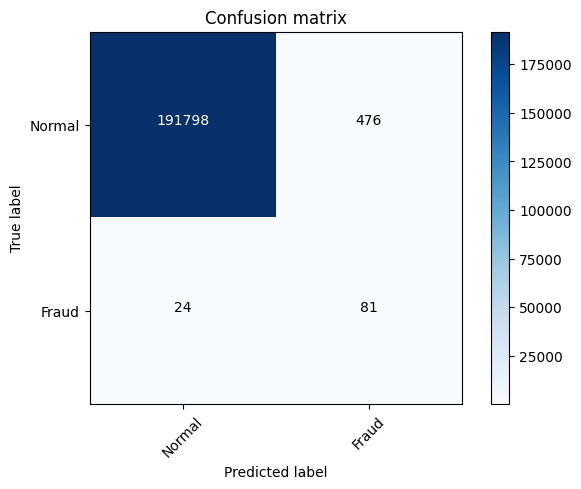

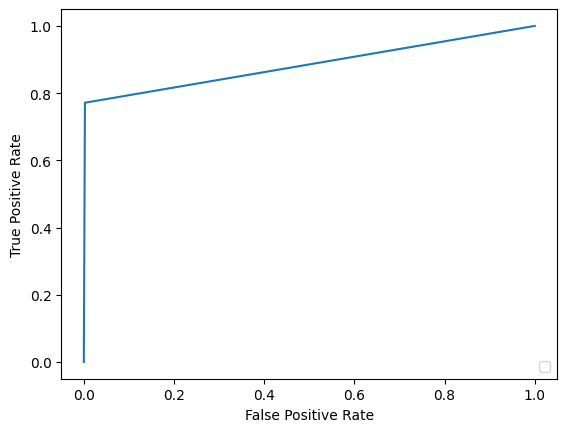

In [24]:
xgb_model_smnc = xgb.XGBRFClassifier(n_estimators = 1500, enable_categorical=True, n_jobs = -1, random_state = 42, tree_method = 'gpu_hist', gpu_id=0)
# X_train_xgb = np.array(X_train)
xgb_model_smnc.fit(X_train_smnc, y_train_smnc)
xgb_y_pred_smnc = xgb_model_smnc.predict(X_test_smnc)

print('------------------------------------\nBase Model + SMOTENC Stats')
get_report(y_test_smnc, xgb_y_pred_smnc)

## Bayesian Optimisation Hyperparameter Tuning

In [56]:
import optuna
import itertools

For smote

In [37]:
def objective_func(trial):
    params = {
        "objective" : "binary:logistic",
        # "eval_metric": "auc",
        'max_depth' : trial.suggest_int('max_depth', 4, 14),
        'learning_rate': trial.suggest_categorical('learning_rate',[0.001, 0.01, 0.1]),
        'n_estimators': trial.suggest_int('n_estimators', 800, 2000, step = 200),
        'subsample': trial.suggest_float('subsample',0.8, 1, log = False),
        'scale_pos_weight' : trial.suggest_int('scale_pos_weight', 1, 100)
    }

    model = xgb.XGBRFClassifier(**params, random_state = 42, tree_method = 'gpu_hist', gpu_id=0)
    model.fit(X_train_sm, y_train_sm)
    y_pred = model.predict(X_val)
    rocauc = roc_auc_score(y_val, y_pred)
    # recall = recall_score(y_test, y_pred)
    return rocauc
    # return recall

# study = optuna.create_study(directions=['maximize', 'maximize'])
study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=300)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-11-03 00:16:55,983] A new study created in memory with name: no-name-72e2979f-0334-4c96-b696-d6e0f3e2ecdb


[I 2023-11-03 00:17:55,536] Trial 0 finished with value: 0.7876354437297415 and parameters: {'max_depth': 4, 'learning_rate': 0.01, 'n_estimators': 1800, 'subsample': 0.9292621879872518, 'scale_pos_weight': 14}. Best is trial 0 with value: 0.7876354437297415.
[I 2023-11-03 00:22:58,011] Trial 1 finished with value: 0.7859811538981629 and parameters: {'max_depth': 14, 'learning_rate': 0.1, 'n_estimators': 1600, 'subsample': 0.9620363046908307, 'scale_pos_weight': 98}. Best is trial 0 with value: 0.7876354437297415.
[I 2023-11-03 00:26:48,155] Trial 2 finished with value: 0.8486370812166292 and parameters: {'max_depth': 14, 'learning_rate': 0.001, 'n_estimators': 1600, 'subsample': 0.897467926569829, 'scale_pos_weight': 27}. Best is trial 2 with value: 0.8486370812166292.
[I 2023-11-03 00:28:51,487] Trial 3 finished with value: 0.8280050664876486 and parameters: {'max_depth': 12, 'learning_rate': 0.1, 'n_estimators': 1200, 'subsample': 0.8762072249429491, 'scale_pos_weight': 52}. Best is

Number of finished trials:  300
Best trial:
  Value: 0.9399797344494755
  Params: 
    max_depth: 14
    learning_rate: 0.001
    n_estimators: 1200
    subsample: 0.8656640532901486
    scale_pos_weight: 10


In [54]:
xgb_model_sm_final = xgb.XGBRFClassifier(**trial.params, n_jobs = -1, random_state = 42, tree_method = 'gpu_hist', gpu_id=0, num_parallel_tree = 1200, num_boost_round = 3)
xgb_model_sm_final.fit(X_train_sm, y_train_sm)

xgb_y_pred_sm_final_val = xgb_model_sm_final.predict(X_val)
xgb_y_pred_sm_final = xgb_model_sm_final.predict(X_test)

[01:23:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "num_boost_round" } are not used.



------------------------------------
Validation Stats
classification_report
------------------------------------
              precision    recall  f1-score   support

   Not Fraud       1.00      0.99      0.99    192274
       Fraud       0.03      0.89      0.06       104

    accuracy                           0.99    192378
   macro avg       0.52      0.94      0.53    192378
weighted avg       1.00      0.99      0.99    192378


recall_score
------------------------------------
0.8942307692307693

roc_auc_score
------------------------------------
0.9399797344494755

confusion_matrix
------------------------------------
Confusion matrix, without normalization
[[189530   2744]
 [    11     93]]
> Correct Predictions: 189623
> Wrong Predictions: 2755


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


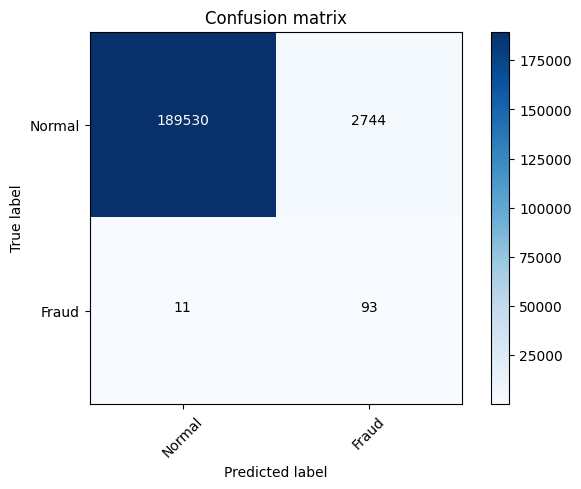

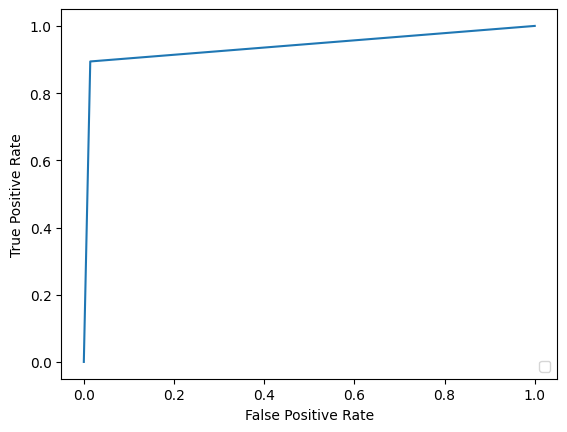

In [55]:
get_report(y_val, xgb_y_pred_sm_final_val)

------------------------------------
Test Stats
classification_report
------------------------------------
              precision    recall  f1-score   support

   Not Fraud       1.00      0.99      0.99    192274
       Fraud       0.03      0.90      0.07       105

    accuracy                           0.99    192379
   macro avg       0.52      0.94      0.53    192379
weighted avg       1.00      0.99      0.99    192379


recall_score
------------------------------------
0.8952380952380953

roc_auc_score
------------------------------------
0.9406602284339263

confusion_matrix
------------------------------------
Confusion matrix, without normalization
[[189598   2676]
 [    11     94]]
> Correct Predictions: 189692
> Wrong Predictions: 2687


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


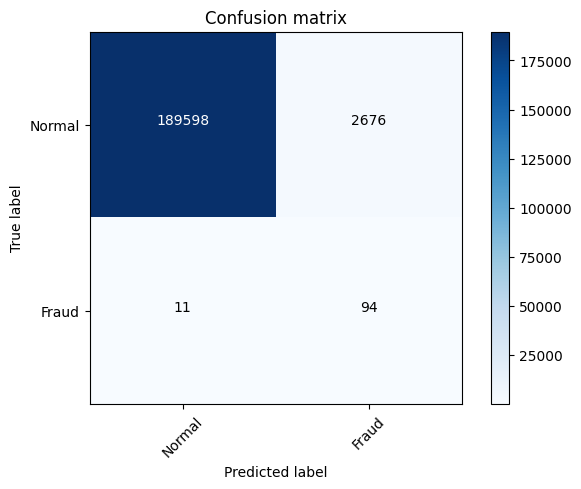

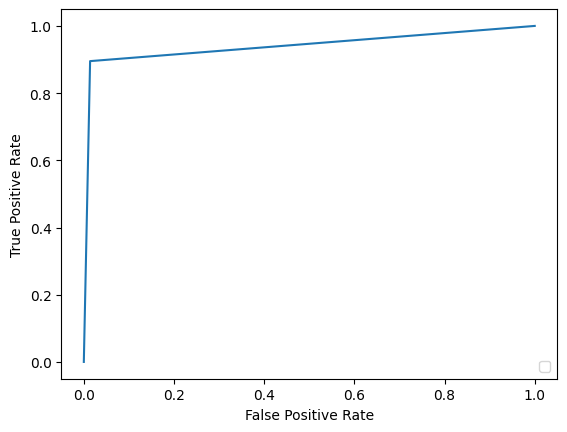

In [46]:
print('------------------------------------\nTest Stats')
get_report(y_test, xgb_y_pred_sm_final)

In [41]:
xgb_model_sm_final.save_model('rf_models/xgbrf_sm.json')

For random undersampling

In [57]:
def objective_func(trial):
    params = {
        "objective" : "binary:logistic",
        # "eval_metric": "auc",
        'max_depth' : trial.suggest_int('max_depth', 4, 10),
        'learning_rate': trial.suggest_categorical('learning_rate',[0.001, 0.01, 0.1]),
        'n_estimators': trial.suggest_int('n_estimators', 800, 2000, step = 200),
        'subsample': trial.suggest_float('subsample',0.8, 1, log = False),
        'scale_pos_weight' : trial.suggest_int('scale_pos_weight', 1, 100)
    }

    model = xgb.XGBRFClassifier(**params, random_state = 42, tree_method = 'gpu_hist', gpu_id=0)
    model.fit(X_train_rus, y_train_rus)
    y_pred = model.predict(X_val)
    rocauc = roc_auc_score(y_val, y_pred)
    # recall = recall_score(y_test, y_pred)
    return rocauc
    # return recall

# study = optuna.create_study(directions=['maximize', 'maximize'])
study_rus = optuna.create_study(direction='maximize')
study_rus.optimize(objective_func, n_trials=100)
print("Number of finished trials: ", len(study_rus.trials))
print("Best trial:")
trial_rus = study_rus.best_trial
print("  Value: {}".format(trial_rus.value))
print("  Params: ")
for key, value in trial_rus.params.items():
    print("    {}: {}".format(key, value))

[I 2023-11-04 18:31:37,903] A new study created in memory with name: no-name-f824feaa-9d2f-4a77-bb83-984e3c7daae5
[I 2023-11-04 18:31:48,570] Trial 0 finished with value: 0.6973643282303059 and parameters: {'max_depth': 7, 'learning_rate': 0.1, 'n_estimators': 1400, 'subsample': 0.9486249428260762, 'scale_pos_weight': 72}. Best is trial 0 with value: 0.6973643282303059.
[I 2023-11-04 18:31:55,952] Trial 1 finished with value: 0.9532127528743036 and parameters: {'max_depth': 8, 'learning_rate': 0.1, 'n_estimators': 800, 'subsample': 0.8491021631885154, 'scale_pos_weight': 25}. Best is trial 1 with value: 0.9532127528743036.
[I 2023-11-04 18:32:04,246] Trial 2 finished with value: 0.9658675199895023 and parameters: {'max_depth': 9, 'learning_rate': 0.01, 'n_estimators': 800, 'subsample': 0.8414159998563211, 'scale_pos_weight': 14}. Best is trial 2 with value: 0.9658675199895023.
[I 2023-11-04 18:32:16,756] Trial 3 finished with value: 0.9617952065201824 and parameters: {'max_depth': 8, '

Number of finished trials:  100
Best trial:
  Value: 0.9734114416845832
  Params: 
    max_depth: 9
    learning_rate: 0.001
    n_estimators: 1000
    subsample: 0.8403126782147267
    scale_pos_weight: 2


------------------------------------
Validation Stats
classification_report
------------------------------------
              precision    recall  f1-score   support

   Not Fraud       1.00      0.97      0.98    192274
       Fraud       0.02      0.98      0.03       104

    accuracy                           0.97    192378
   macro avg       0.51      0.97      0.51    192378
weighted avg       1.00      0.97      0.98    192378


recall_score
------------------------------------
0.9807692307692307

roc_auc_score
------------------------------------
0.9734114416845832

confusion_matrix
------------------------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Confusion matrix, without normalization
[[185747   6527]
 [     2    102]]
> Correct Predictions: 185849
> Wrong Predictions: 6529


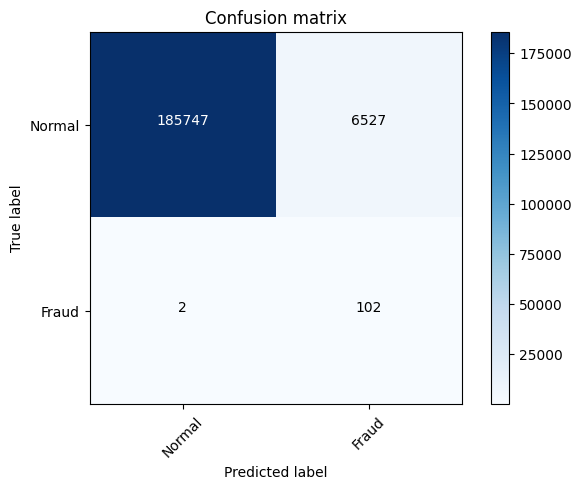

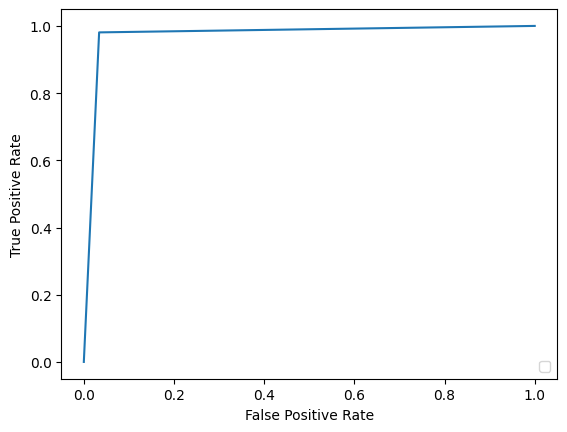

In [58]:
xgb_model_rus_final = xgb.XGBRFClassifier(**trial_rus.params, n_jobs = -1, random_state = 42, tree_method = 'gpu_hist', gpu_id=0)
xgb_model_rus_final.fit(X_train_rus, y_train_rus)

xgb_y_pred_sm_final_val = xgb_model_rus_final.predict(X_val)
xgb_y_pred_sm_final = xgb_model_rus_final.predict(X_test)

get_report(y_val, xgb_y_pred_sm_final_val)

------------------------------------
Validation Stats
classification_report
------------------------------------
              precision    recall  f1-score   support

   Not Fraud       1.00      0.97      0.98    192274
       Fraud       0.02      0.95      0.03       105

    accuracy                           0.97    192379
   macro avg       0.51      0.96      0.51    192379
weighted avg       1.00      0.97      0.98    192379


recall_score
------------------------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.9523809523809523

roc_auc_score
------------------------------------
0.9592719120580402

confusion_matrix
------------------------------------
Confusion matrix, without normalization
[[185768   6506]
 [     5    100]]
> Correct Predictions: 185868
> Wrong Predictions: 6511


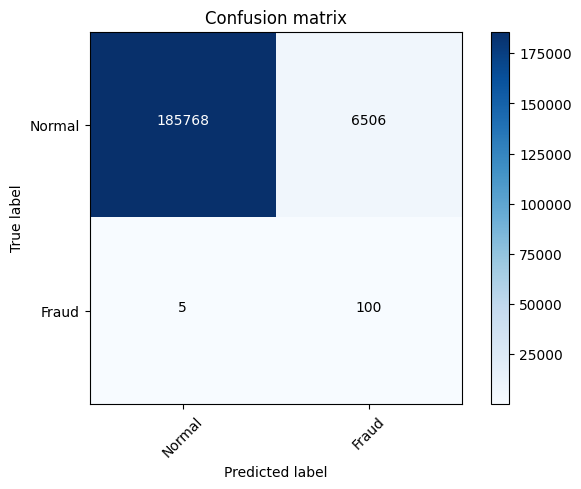

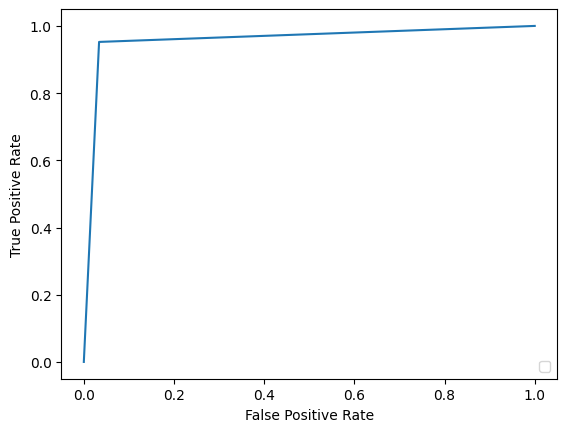

In [67]:
get_report(y_test, xgb_y_pred_sm_final)

In [60]:
xgb_model_rus_final.save_model('rf_models/xgbrf_rus.json')

Random Undersampling Shap Plots

In [33]:
import shap
shap.initjs()


loaded_model_rus = xgb.XGBRFClassifier()
loaded_model_rus.load_model('rf_models/xgbrf_rus.json')

x_sample_rus = X_train_rus.astype('float') # convert to numpy
explainer_xgb = shap.Explainer(loaded_model_rus, x_sample_rus) # create explainer object
shap_values_xgb_rus = explainer_xgb(x_sample_rus) # calculate shap values

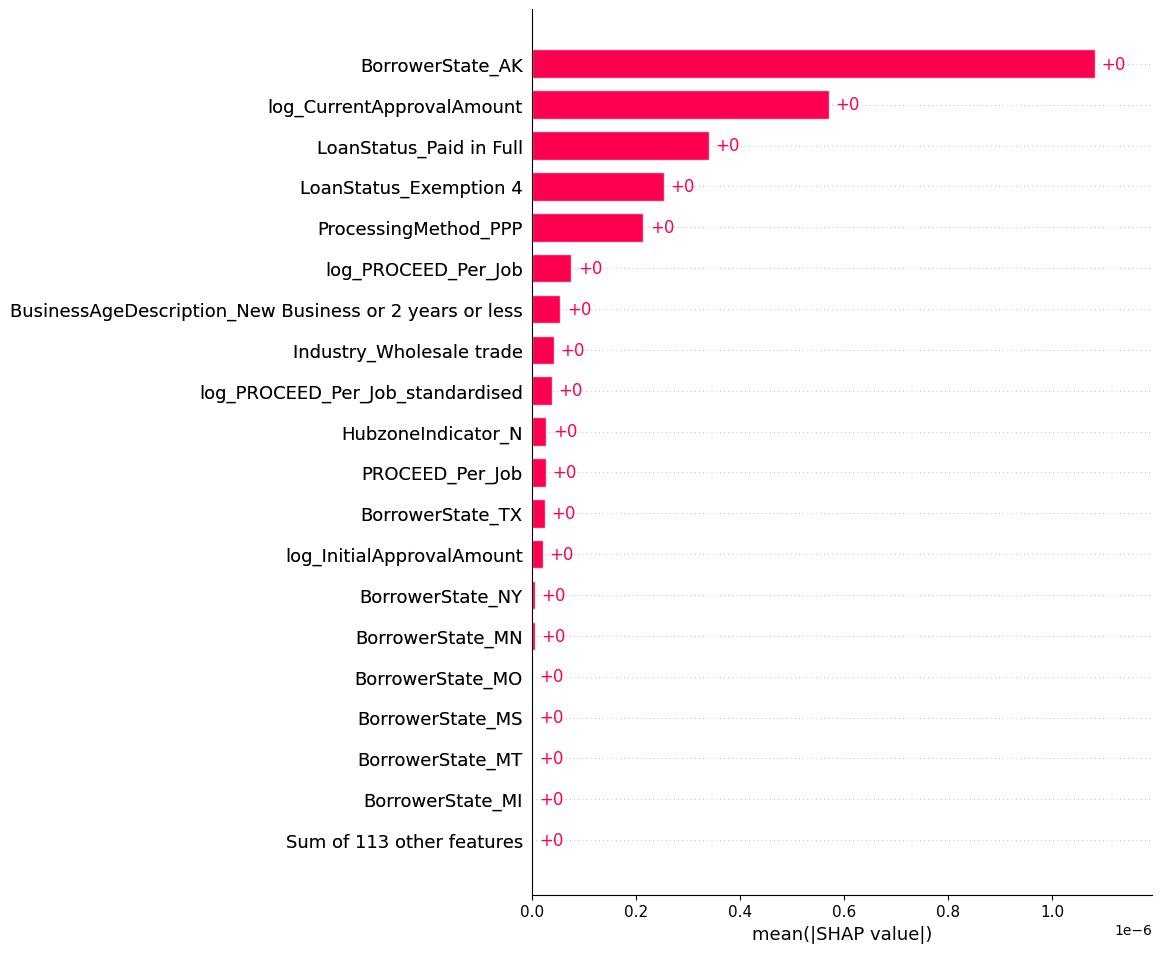

In [34]:
shap.plots.bar(shap_values_xgb_rus, max_display=20)

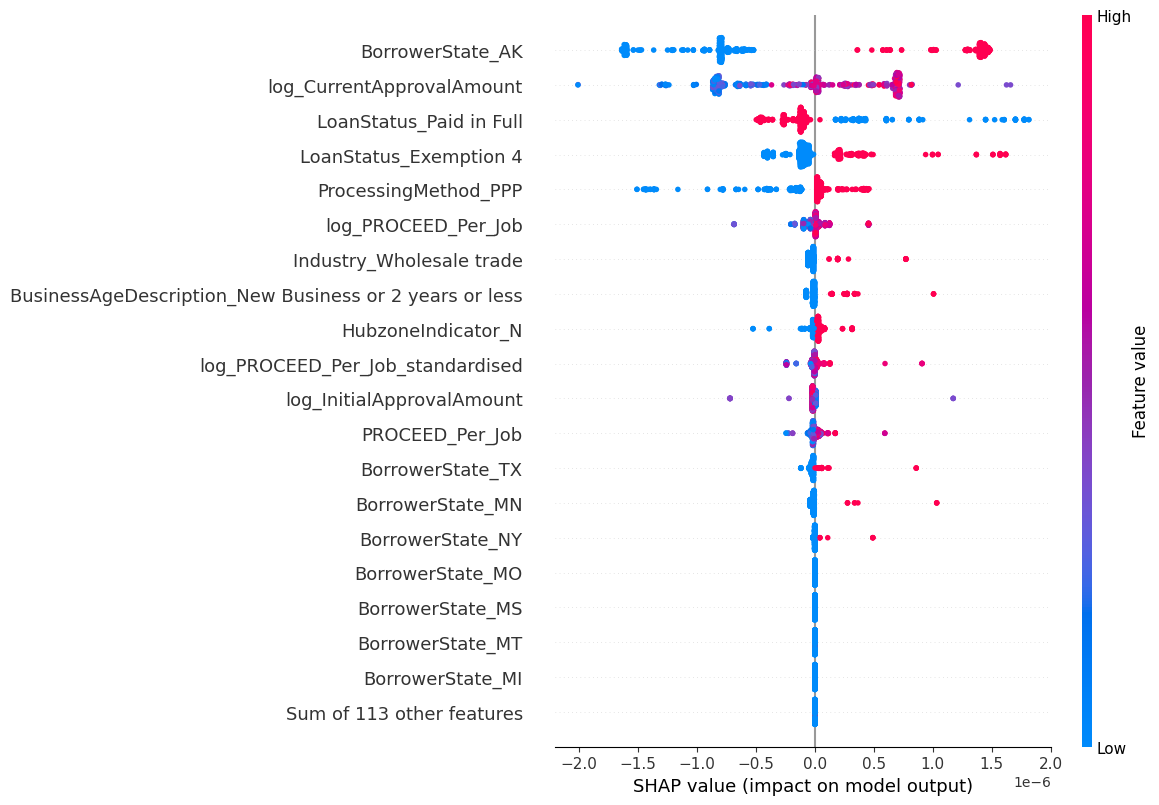

In [63]:
shap.plots.beeswarm(shap_values_xgb_rus, max_display=20)

SMOTE Shap Plots

In [30]:
loaded_model = xgb.XGBRFClassifier()
loaded_model.load_model('rf_models/xgbrf_sm.json')

In [27]:
import shap
shap.initjs()

x_sample = X_train_sm.astype('float') # convert to numpy
explainer_xgb = shap.Explainer(loaded_model, x_sample) # create explainer object
shap_values_xgb = explainer_xgb(x_sample) # calculate shap values

100%|===================| 1152428/1153642 [03:50<00:00]        

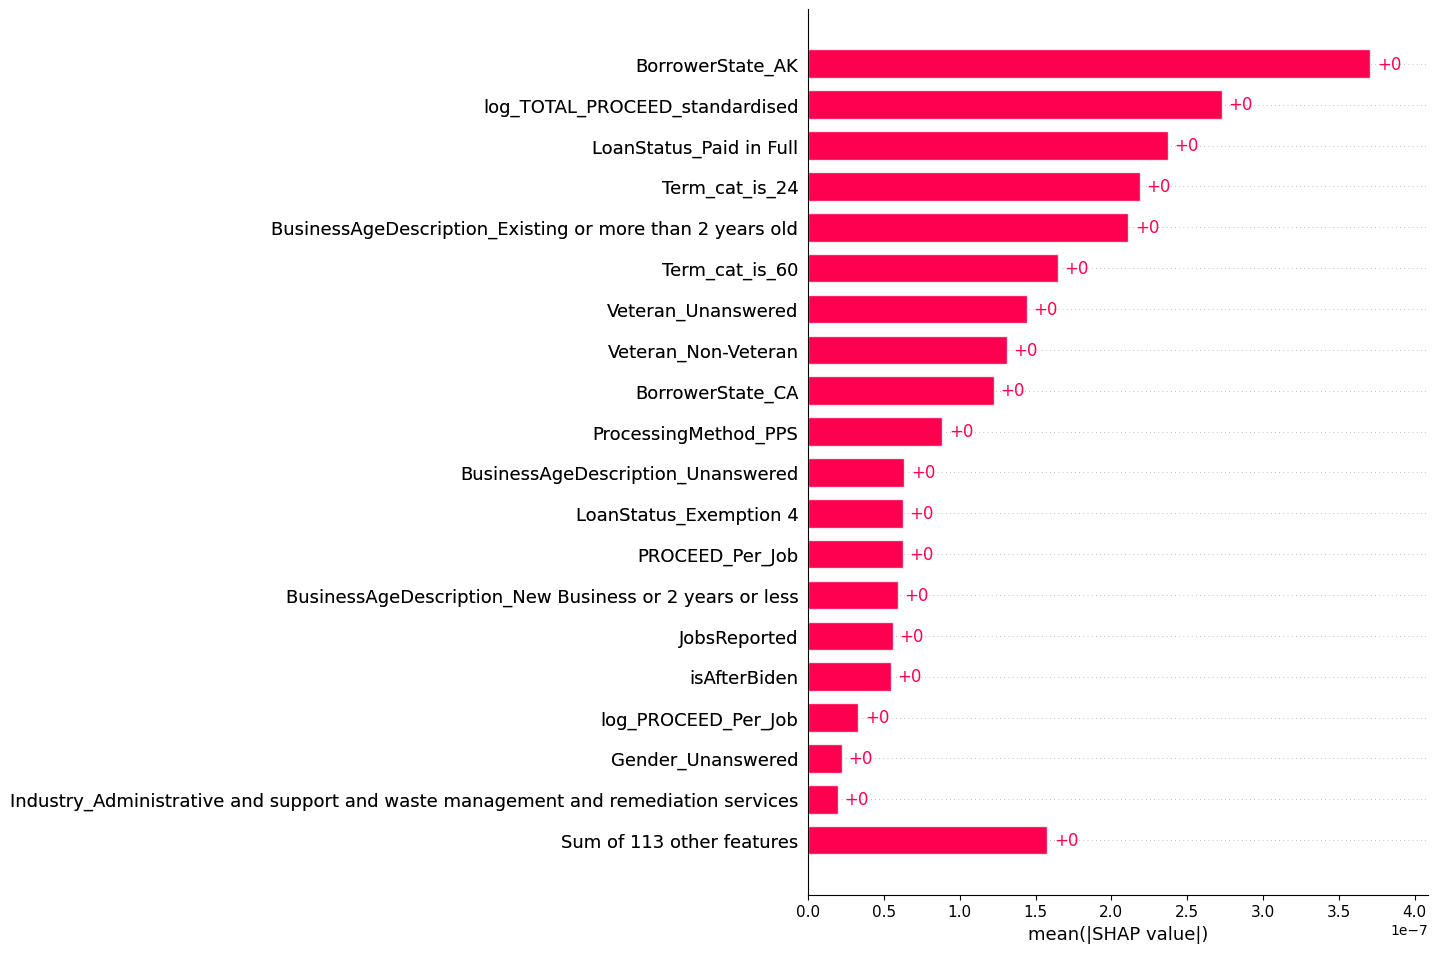

In [28]:
shap.plots.bar(shap_values_xgb, max_display=20)

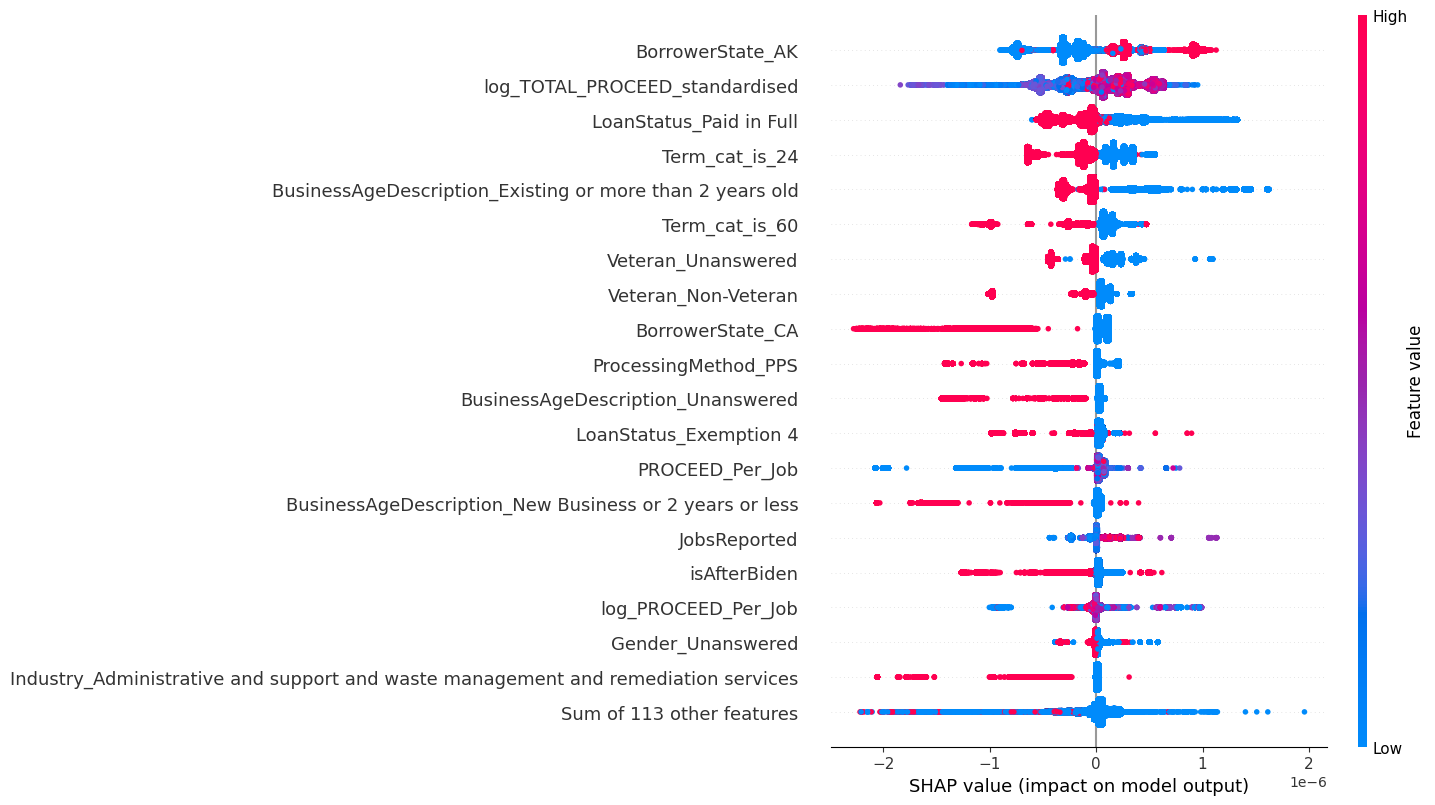

In [29]:
shap.plots.beeswarm(shap_values_xgb, max_display=20)

# XGboost boosting

------------------------------------
Validation Stats
classification_report
------------------------------------
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    192274
       Fraud       0.58      0.46      0.51       105

    accuracy                           1.00    192379
   macro avg       0.79      0.73      0.76    192379
weighted avg       1.00      1.00      1.00    192379


recall_score
------------------------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.45714285714285713

roc_auc_score
------------------------------------
0.7284804126254347

confusion_matrix
------------------------------------
Confusion matrix, without normalization
[[192239     35]
 [    57     48]]
> Correct Predictions: 192287
> Wrong Predictions: 92


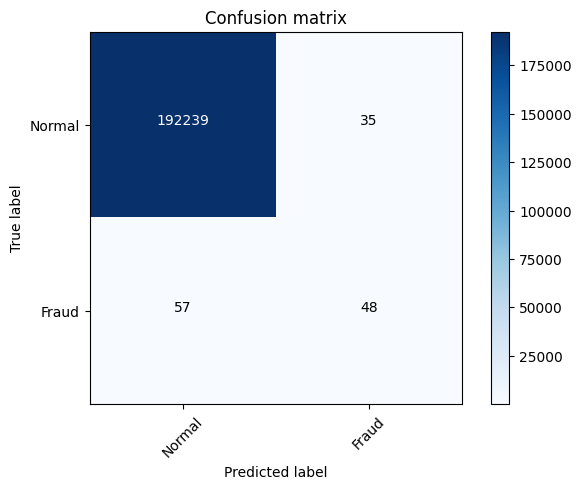

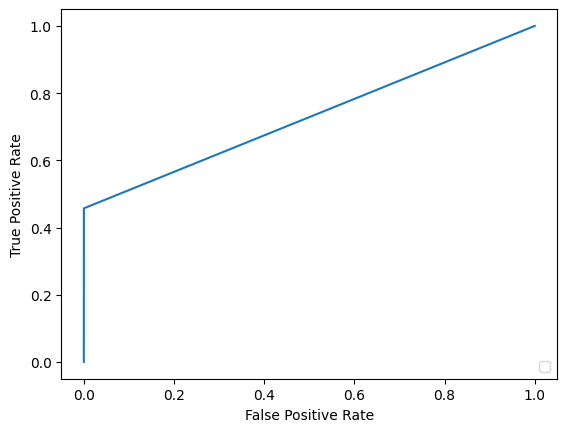

In [31]:
xgb_boost = xgb.XGBClassifier(n_estimators = 100, n_jobs = -1, random_state = 42, tree_method = 'gpu_hist', gpu_id=0 )
xgb_boost.fit(X_train, y_train)
xgb_boost_pred = xgb_boost.predict(X_test)

get_report(y_test, xgb_boost_pred)

------------------------------------
Validation Stats
classification_report
------------------------------------
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    192274
       Fraud       0.13      0.84      0.22       105

    accuracy                           1.00    192379
   macro avg       0.56      0.92      0.61    192379
weighted avg       1.00      1.00      1.00    192379


recall_score
------------------------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.8380952380952381

roc_auc_score
------------------------------------
0.9174535397649288

confusion_matrix
------------------------------------
Confusion matrix, without normalization
[[191661    613]
 [    17     88]]
> Correct Predictions: 191749
> Wrong Predictions: 630


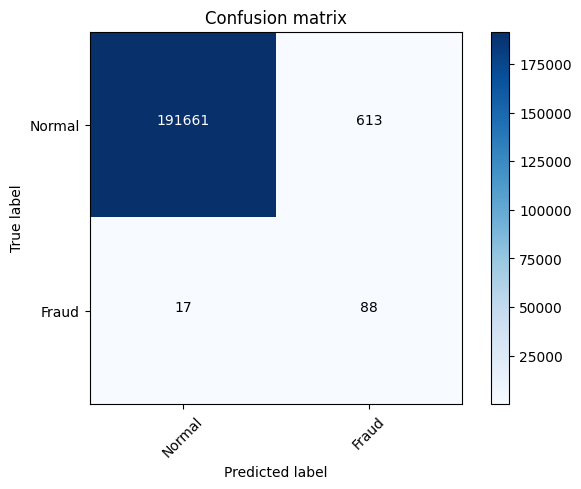

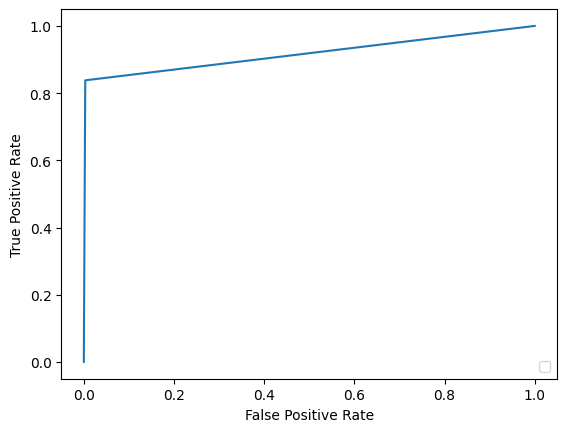

In [36]:
xgb_boost_sm = xgb.XGBClassifier(n_estimators = 5, n_jobs = -1, random_state = 42, tree_method = 'gpu_hist', gpu_id=0)
xgb_boost_sm.fit(X_train_sm, y_train_sm)
xgb_boost_sm_pred = xgb_boost_sm.predict(X_test)

get_report(y_test, xgb_boost_sm_pred)